--- Instant: compiling ---


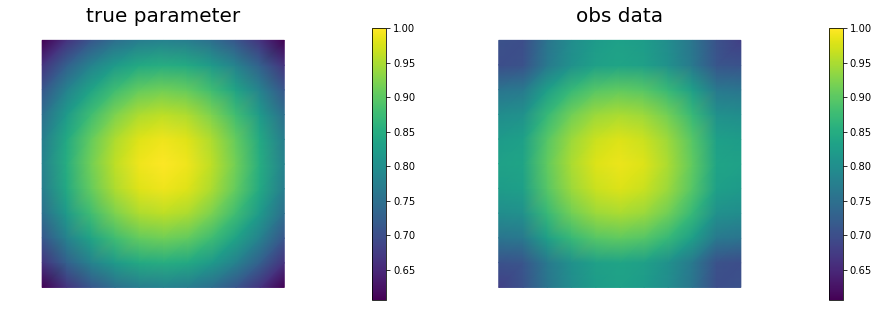

AttributeError: 'list' object has no attribute 'shape'

In [1]:
from __future__ import absolute_import, division, print_function

from hippylib import nb
import dolfin as dl
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
%matplotlib inline

import logging
logging.getLogger('FFC').setLevel(logging.ERROR)
logging.getLogger('UFC').setLevel(logging.ERROR)
dl.set_log_active(False)

sys.path.insert(0,'/home/fenics/Installations/MUQ_INSTALL/lib')
from IPython.display import Image

# MUQ Includes
import pymuqModeling as mm # Needed for Gaussian distribution
import pymuqApproximation as ma # Needed for Gaussian processes
import pymuqSamplingAlgorithms as ms # Needed for MCMC

# Setup function space
nx = ny = 10
mesh = dl.RectangleMesh(dl.Point(0, 0),dl.Point(1,1),nx,ny,"right")
V = dl.FunctionSpace(mesh, 'P', 1)


# PAT forward solver for use with MUQ
class PAT_forward(mm.PyModPiece):
    
    def __init__(self, time_final, numSteps, c, V):
        """ 
        INPUTS:
        - time_final = final time
        - numSteps = number of time steps
        - c = speed of sound
        """
        mm.PyModPiece.__init__(self, [V.dim()],[V.dim()])
                  
        self.T_f = time_final
        self.numSteps = numSteps
        self.dt = self.T_f / self.numSteps
        self.c = c
        self.V = V
        
        self.p_trial = dl.TrialFunction(self.V)
        self.v = dl.TestFunction(self.V)
            
    def EvaluateImpl(self, inputs):
        """
        INPUTS:
        - inputs = parameter of interest as a numpy array
        
        OUTPUT:
        - solution of PAT forward problem as numpy array
        """
        m = dl.Function(self.V)
        m.vector().set_local(inputs[0])
        
        p_n = dl.interpolate(m, self.V)
        p_nm1 = dl.interpolate(m, self.V)
        p_trial = self.p_trial
        v = self.v
        
        F = (self.c**2)*(self.dt**2)*dl.inner(dl.grad(p_trial), dl.grad(v))*dl.dx - 2.*p_n*v*dl.dx + p_trial*v*dl.dx + p_nm1*v*dl.dx 
        a, L = dl.lhs(F), dl.rhs(F)
        
        # Time-stepping
        p = dl.Function(self.V)
        t = 0
        for n in range(self.numSteps):
            # Update current timtime
            t += self.dt

            # Compute solution
            dl.solve(a == L, p)

            # Update previous solution
            p_nm1.assign(p_n)
            p_n.assign(p)

        out = p.vector().get_local()
        
        self.outputs = [out]

        
# Compute the synthetic data        
time_final = 0.05
numSteps = 100
c = 1.5
test = PAT_forward(time_final, numSteps, c, V)
m = dl.interpolate(dl.Expression('exp(-(x[0]-0.5)*(x[0]-0.5) -(x[1]-0.5)*(x[1]-0.5))', degree=2), V)
obsData = test.Evaluate([m.vector().get_local()])   

# plot true parameter and observed data
data = dl.Function(V)
data.vector().set_local(obsData[0])
nb.multi1_plot( [ m , data ] , ["true parameter", "obs data"], same_colorbar=True)
plt.show()

fwdSolver = PAT_forward(time_final, numSteps, c, V)


# Setup the Prior
#logPriorMu = 2*np.ones(V.dim())
logPriorMu = m.vector().get_local()
logPriorCov = 0.02*np.eye(V.dim())
logPrior = mm.Gaussian(logPriorMu, logPriorCov).AsDensity()

# Setup the Likelihood  
noiseVar = 1e-4
noiseCov = noiseVar*np.eye(obsData.shape[0])
likelihood = mm.Gaussian(obsData, noiseCov).AsDensity()

# MUQ stuff needed for posterior
posteriorPiece = mm.DensityProduct(2)
p_0 = mm.IdentityOperator(V.dim())


# Setup a graph of the work
graph = mm.WorkGraph()

# Forward model nodes and edges
graph.AddNode(p_0, "p_0")
#graph.AddNode(obsOperator, "B")
graph.AddNode(fwdSolver, "u")

graph.AddEdge("p_0", 0, "u", 0)
#graph.AddEdge("u", 0, "B", 0)

# Other nodes and edges
graph.AddNode(likelihood, "Likelihood")
graph.AddNode(logPrior, "Prior")
graph.AddNode(posteriorPiece,"Posterior")

#graph.AddEdge("B", 0, "Likelihood", 0)
graph.AddEdge("u", 0, "Likelihood", 0)
graph.AddEdge("p_0", 0, "Prior", 0)
graph.AddEdge("Prior",0,"Posterior",0)
graph.AddEdge("Likelihood",0, "Posterior",1)

graph.Visualize("PosteriorGraph.png")
Image(filename='PosteriorGraph.png') 


# Create the graph 
problem = ms.SamplingProblem(graph.CreateModPiece("Posterior"))


# Setup sampler
proposalOptions = dict()
proposalOptions['Method'] = 'AMProposal'
proposalOptions['ProposalVariance'] = 1e-1
proposalOptions['AdaptSteps'] = 100
proposalOptions['AdaptStart'] = 1000
proposalOptions['AdaptScale'] = 0.1

kernelOptions = dict()
kernelOptions['Method'] = 'MHKernel'
kernelOptions['Proposal'] = 'ProposalBlock'
kernelOptions['ProposalBlock'] = proposalOptions

options = dict()
options['NumSamples'] = 100
options['ThinIncrement'] = 1
options['BurnIn'] = 1
options['KernelList'] = 'Kernel1'
options['PrintLevel'] = 3
options['Kernel1'] = kernelOptions

mcmc = ms.SingleChainMCMC(options,problem)

# Choose a staring point and sample
startPt = np.log(8.0) * np.ones((V.dim()))
samps = mcmc.Run(startPt)



# Look at MCMC statistics
ess = samps.ESS()
print('Effective Sample Size = \n', ess)

sampMean = samps.Mean()
print('\nSample mean = \n', sampMean)

sampCov = samps.Covariance()
print('\nSample Covariance = \n', sampCov)

mcErr = np.sqrt( samps.Variance() / ess)
print('\nEstimated MC error in mean = \n', mcErr)

mean = dl.Function(V)
mean.vector().set_local(sampMean)
nb.plot(mean)
plt.show()
 
sampMat = samps.AsMatrix()

plt.plot(sampMat.T)
plt.show()

# Look at predictions based on posterior samples
predSamps = np.zeros((numPts, sampMat.shape[1]))

predModel = graph.CreateModPiece("u")

for i in range(sampMat.shape[1]):
    predSamps[:,i] = predModel.Evaluate([ sampMat[:,i] ])[0]